In [5]:
import pandas as pd
import numpy as np
import json
import requests
import pyarrow.parquet as pq
import os
import glob
import textstat
import string
from collections import Counter
import math
import re
from huggingface_hub import login
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, AutoModelForSeq2SeqLM
import torch
import pandas as pd
import numpy as np
import json
import re
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from typing import List, Dict, Tuple, Optional, Union
from transformers import AutoTokenizer, AutoModelForCausalLM
from sklearn.metrics import accuracy_score, confusion_matrix
import sqlite3
import time
import random


In [6]:
def convert_parquet_to_csv(parquet_file, csv_file=None):

    if csv_file is None:
        csv_file = os.path.splitext(parquet_file)[0] + '.csv'
    

    print(f"Reading {parquet_file}...")
    df = pd.read_parquet(parquet_file)
    

    print(f"Writing to {csv_file}...")
    df.to_csv(csv_file, index=False)
    
    print(f"Conversion complete: {parquet_file} → {csv_file}")
    print(f"CSV file size: {os.path.getsize(csv_file) / (1024 * 1024):.2f} MB")
    
    return csv_file

In [7]:
# convert_parquet_to_csv("test-asdiv.parquet")

In [8]:
class SimpleMathProblemTaxonomyScorer:
    """
    An implementation of the math problem taxonomy scorer that doesn't require spaCy.
    Analyzes math word problems across three dimensions:
    1. Semantic Complexity: linguistic features
    2. Procedural Complexity: operations and steps
    3. Cognitive Complexity: conceptual difficulty and knowledge requirements
    """
    
    def __init__(self):
        # Keywords for operation detection
        self.operation_keywords = {
            'addition': ['add', 'sum', 'plus', 'total', 'more', 'increase', 'gain', 'together'],
            'subtraction': ['subtract', 'minus', 'difference', 'less', 'decrease', 'take away', 'reduce', 'remain'],
            'multiplication': ['multiply', 'times', 'product', 'twice', 'triple', 'doubled', 'each'],
            'division': ['divide', 'split', 'quotient', 'per', 'share', 'ratio', 'each'],
            'percentage': ['percent', 'percentage', '%', 'discount', 'interest', 'tax'],
            'fractions': ['fraction', 'half', 'third', 'quarter', 'fifth', 'partial'],
            'ratios': ['ratio', 'proportion', 'rate', 'scale', 'compared to'],
            'algebraic': ['unknown', 'variable', 'equation', 'solve for', 'represent']
        }
        
        # Domain knowledge indicators
        self.domain_knowledge = {
            'geometry': ['angle', 'circle', 'square', 'triangle', 'rectangle', 'perimeter', 'area', 'volume'],
            'finance': ['dollar', 'cent', 'money', 'currency', 'cost', 'price', 'sell', 'buy', 'profit', 'loss'],
            'physics': ['speed', 'distance', 'time', 'velocity', 'acceleration', 'force'],
            'probability': ['probability', 'chance', 'likely', 'random', 'outcome', 'event'],
            'statistics': ['average', 'mean', 'median', 'mode', 'range', 'data', 'sample']
        }
        
        # Common stopwords for lexical analysis
        self.stopwords = set([
            'a', 'an', 'the', 'and', 'or', 'but', 'if', 'because', 'as', 'what', 
            'when', 'where', 'how', 'who', 'which', 'this', 'that', 'these', 'those',
            'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had',
            'do', 'does', 'did', 'can', 'could', 'will', 'would', 'should', 'must',
            'to', 'of', 'in', 'on', 'at', 'by', 'for', 'with', 'about', 'from'
        ])
        
    def _tokenize(self, text):
       
        # Remove punctuation
        text = text.translate(str.maketrans('', '', string.punctuation))
        # Split on whitespace
        return text.lower().split()
    
    def _count_sentences(self, text):
        
        # Simple sentence splitter using common ending punctuation
        return len(re.split(r'[.!?]+', text)) - 1
    
    def _count_math_operations(self, text):
        
        operations = set()
        total_operations = 0
        
        # Convert text to lowercase for case-insensitive matching
        text_lower = text.lower()
        
        # Check each operation type
        for op_type, keywords in self.operation_keywords.items():
            for keyword in keywords:
                if re.search(r'\b' + keyword + r'\b', text_lower):
                    operations.add(op_type)
                    total_operations += 1
        
        return {
            'unique_operations': len(operations),
            'total_operations': total_operations,
            'operations_found': list(operations)
        }
    
    def _detect_domain_knowledge(self, text):
       
        domains = set()
        
        # Convert text to lowercase for case-insensitive matching
        text_lower = text.lower()
        
        # Check each domain type
        for domain, keywords in self.domain_knowledge.items():
            for keyword in keywords:
                if re.search(r'\b' + keyword + r'\b', text_lower):
                    domains.add(domain)
        
        return {
            'domains_required': list(domains),
            'domain_count': len(domains)
        }
    
    def _calculate_lexical_diversity(self, text):
        
        tokens = self._tokenize(text)
        tokens = [t for t in tokens if t not in self.stopwords]
        
        if not tokens:
            return 0
            
        # Count unique words (types)
        types = set(tokens)
        
        # Calculate Type-Token Ratio
        ttr = len(types) / len(tokens)
        return ttr
    
    def _estimate_reading_difficulty(self, text):
        
        word_count = len(self._tokenize(text))
        sentence_count = max(1, self._count_sentences(text))
        
        # Average words per sentence
        avg_words_per_sentence = word_count / sentence_count
        
        # Count of "difficult" words (approximated by length > 6)
        difficult_words = sum(1 for word in self._tokenize(text) if len(word) > 6)
        
        # Simple readability score (1-5 scale)
        score = min(5, 1 + (avg_words_per_sentence / 10) + (difficult_words / word_count * 4))
        
        return score
    
    def analyze_semantic_complexity(self, text):
        
        # Lexical diversity calculation
        lexical_diversity = self._calculate_lexical_diversity(text)
        
        # Syntactic complexity (simplified estimate)
        tokens = self._tokenize(text)
        avg_word_length = sum(len(word) for word in tokens) / max(1, len(tokens))
        
        # Number of commas as a simple proxy for sentence complexity
        comma_count = text.count(',')
        
        # Reading difficulty
        readability_score = self._estimate_reading_difficulty(text)
        
        # Presence of question marks (indicating questions)
        question_count = text.count('?')
        
        # Map raw scores to 1-5 scale
        lexical_diversity_score = self._map_to_scale(lexical_diversity, 0.3, 0.8)
        syntactic_complexity_score = self._map_to_scale(
            avg_word_length + (comma_count / max(1, len(text.split()))), 3, 7
        )
        
        # Check for conditional language
        conditional_phrases = ['if', 'then', 'when', 'given that', 'assuming']
        conditional_count = sum(1 for phrase in conditional_phrases if phrase in text.lower())
        conditional_score = self._map_to_scale(conditional_count, 0, 3)
        
        # Compute weighted average for overall semantic complexity
        overall_semantic_score = (lexical_diversity_score + syntactic_complexity_score + 
                                 readability_score + conditional_score) / 4
        
        return {
            "semantic_complexity_score": round(overall_semantic_score, 2),
            "lexical_diversity_score": round(lexical_diversity_score, 2),
            "syntactic_complexity_score": round(syntactic_complexity_score, 2),
            "readability_score": round(readability_score, 2),
            "conditional_score": round(conditional_score, 2),
            "raw_metrics": {
                "lexical_diversity": lexical_diversity,
                "avg_word_length": avg_word_length,
                "comma_count": comma_count,
                "question_count": question_count
            }
        }
    
    def analyze_procedural_complexity(self, text):
        
        # Count operations
        op_data = self._count_math_operations(text)
        
        # Number operations (count of numbers in the problem)
        numbers = re.findall(r'\b\d+(?:\.\d+)?\b', text)
        number_count = len(numbers)
        
        # Step dependencies (estimate based on sentence count and operation count)
        sentence_count = self._count_sentences(text)
        
        # More sentences often indicate more steps
        estimated_steps = max(sentence_count, op_data['unique_operations'])
        
        # Score for number of operations
        operations_score = self._map_to_scale(op_data['unique_operations'], 1, 4)
        
        # Score for operation complexity (higher weight for advanced operations)
        operation_complexity = 0
        advanced_ops = ['percentage', 'fractions', 'ratios', 'algebraic']
        for op in op_data['operations_found']:
            if op in advanced_ops:
                operation_complexity += 2
            else:
                operation_complexity += 1
                
        operation_complexity_score = self._map_to_scale(operation_complexity, 1, 8)
        
        # Score for step dependencies
        steps_score = self._map_to_scale(estimated_steps, 1, 5)
        
        # Compute weighted average for overall procedural complexity
        overall_procedural_score = (operations_score + operation_complexity_score + steps_score) / 3
        
        return {
            "procedural_complexity_score": round(overall_procedural_score, 2),
            "operations_count_score": round(operations_score, 2),
            "operation_complexity_score": round(operation_complexity_score, 2),
            "steps_score": round(steps_score, 2),
            "raw_metrics": {
                "unique_operation_count": op_data['unique_operations'],
                "total_operation_mentions": op_data['total_operations'],
                "operations_detected": op_data['operations_found'],
                "number_count": number_count,
                "estimated_steps": estimated_steps
            }
        }
    
    def analyze_cognitive_complexity(self, text):
        
        # Domain knowledge requirements
        domain_data = self._detect_domain_knowledge(text)
        
        # Look for indicators of abstract reasoning
        abstract_indicators = ['pattern', 'rule', 'formula', 'logic', 'general', 'abstract']
        abstract_count = sum(1 for indicator in abstract_indicators if indicator in text.lower())
        
        # Multi-step indicator phrases
        multi_step_indicators = ['first', 'then', 'next', 'after', 'before', 'finally', 'lastly']
        multi_step_count = sum(1 for indicator in multi_step_indicators if indicator in text.lower())
        
        # Conditional reasoning indicators
        conditional_indicators = ['if', 'when', 'either', 'or', 'unless', 'otherwise', 'suppose']
        conditional_count = sum(1 for indicator in conditional_indicators if indicator in text.lower())
        
        # Domain knowledge score
        domain_score = self._map_to_scale(domain_data['domain_count'], 0, 3)
        
        # Abstract reasoning score
        abstract_score = self._map_to_scale(abstract_count, 0, 3)
        
        # Multi-step dependency score
        multi_step_score = self._map_to_scale(multi_step_count, 0, 4)
        
        # Conditional reasoning score
        conditional_score = self._map_to_scale(conditional_count, 0, 3)
        
        # Compute weighted average for overall cognitive complexity
        overall_cognitive_score = (domain_score + abstract_score + multi_step_score + conditional_score) / 4
        
        return {
            "cognitive_complexity_score": round(overall_cognitive_score, 2),
            "domain_knowledge_score": round(domain_score, 2),
            "abstract_reasoning_score": round(abstract_score, 2),
            "multi_step_score": round(multi_step_score, 2),
            "conditional_reasoning_score": round(conditional_score, 2),
            "raw_metrics": {
                "domains_required": domain_data['domains_required'],
                "domain_count": domain_data['domain_count'],
                "abstract_indicator_count": abstract_count,
                "multi_step_indicator_count": multi_step_count,
                "conditional_indicator_count": conditional_count
            }
        }
    
    def _map_to_scale(self, value, min_val, max_val, target_min=1, target_max=5):
        # Ensure the value is within the min-max range
        value = max(min_val, min(max_val, value))
        
        # Calculate the scaled value
        scaled = ((value - min_val) / (max_val - min_val)) * (target_max - target_min) + target_min
        
        return scaled
    
    def score_problem(self, problem_text):
        
        semantic_analysis = self.analyze_semantic_complexity(problem_text)
        procedural_analysis = self.analyze_procedural_complexity(problem_text)
        cognitive_analysis = self.analyze_cognitive_complexity(problem_text)
        
        # Calculate overall complexity as average of the three dimensions
        overall_score = (semantic_analysis['semantic_complexity_score'] + 
                         procedural_analysis['procedural_complexity_score'] + 
                         cognitive_analysis['cognitive_complexity_score']) / 3
        
        return {
            "problem": problem_text,
            "overall_complexity_score": round(overall_score, 2),
            "semantic_complexity": semantic_analysis,
            "procedural_complexity": procedural_analysis,
            "cognitive_complexity": cognitive_analysis
        }

    def categorize_problem(self, problem_text):
        
        scores = self.score_problem(problem_text)
        
        # Function to convert score to category
        def score_to_category(score):
            if score < 2.5:
                return "Low"
            elif score < 3.75:
                return "Medium"
            else:
                return "High"
        
        # Create categorization
        categorization = {
            "problem": problem_text,
            "semantic_complexity": score_to_category(scores["semantic_complexity"]["semantic_complexity_score"]),
            "procedural_complexity": score_to_category(scores["procedural_complexity"]["procedural_complexity_score"]),
            "cognitive_complexity": score_to_category(scores["cognitive_complexity"]["cognitive_complexity_score"]),
            "overall_complexity": score_to_category(scores["overall_complexity_score"]),
            "detailed_scores": scores
        }
        
        return categorization

In [9]:
# Function to process a dataset
def analyse_math_dataset(dataset_path, output_path=None, sample_size=None,data=None):
    """
    Analyze a dataset of math problems using the taxonomy
    
    Args:
        dataset_path (str): Path to CSV file with math problems
        output_path (str, optional): Path to save results
        sample_size (int, optional): Number of problems to sample (None for all)
    """
    if dataset_path == "":
        df = data
    
    else:
        df = pd.read_csv(dataset_path)
    
    # Take sample if specified
    if sample_size and sample_size < len(df):
        df = df.sample(sample_size, random_state=42)
    
    # Initialize scorer
    scorer = SimpleMathProblemTaxonomyScorer()
    
    # Determine which column contains the problems
    problem_col = None
    for col in ['question', 'problem', 'text','question_concat']:
        if col in df.columns:
            problem_col = col
            break
    
    if not problem_col:
        raise ValueError("Could not identify column with problem text")
    
    # Process each problem
    results = []
    for idx, row in df.iterrows():
        # print(f"Processing problem {idx+1}/{len(df)}")
        
        problem_text = row[problem_col]
        try:
            analysis = scorer.score_problem(problem_text)
            categorization = scorer.categorize_problem(problem_text)
            results.append(categorization)
        except Exception as e:
            print(f"Error processing problem: {e}")
            continue
    
    # Create results dataframe
    results_df = pd.DataFrame([
        {
            'problem': r['problem'],
            'semantic_complexity': r['semantic_complexity'],
            'procedural_complexity': r['procedural_complexity'],
            'cognitive_complexity': r['cognitive_complexity'],
            'overall_complexity': r['overall_complexity'],
            'semantic_score': r['detailed_scores']['semantic_complexity']['semantic_complexity_score'],
            'procedural_score': r['detailed_scores']['procedural_complexity']['procedural_complexity_score'],
            'cognitive_score': r['detailed_scores']['cognitive_complexity']['cognitive_complexity_score'],
            'overall_score': r['detailed_scores']['overall_complexity_score'],
        }
        for r in results
    ])
    
    # Save results if output path specified
    if output_path:
        results_df.to_csv(output_path, index=False)
        
        # Save detailed results as JSON
        with open(output_path.replace('.csv', '_detailed.json'), 'w') as f:
            json.dump(results, f, indent=2)
    
    # Analyze distribution of complexity levels
    category_counts = {
        'semantic_complexity': results_df['semantic_complexity'].value_counts().to_dict(),
        'procedural_complexity': results_df['procedural_complexity'].value_counts().to_dict(),
        'cognitive_complexity': results_df['cognitive_complexity'].value_counts().to_dict(),
        'overall_complexity': results_df['overall_complexity'].value_counts().to_dict()
    }
    
    print("\nDistribution of complexity levels:")
    for dimension, counts in category_counts.items():
        print(f"{dimension}: {counts}")
    
    return results_df, results




In [10]:

class AdaptiveCoTFramework:
    """
    A framework for systematically evaluating different Chain-of-Thought (CoT)
    prompting strategies based on problem difficulty taxonomy.
    """
    
    
    def __init__(self, model_name="deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B", taxonomy_df=None):
        
        self.model_name = model_name
        self.taxonomy_df = taxonomy_df
    
        # Load model and tokenizer
        print(f"Loading model and tokenizer: {model_name}")
        # For llama and Deepseek models only
        self.tokenizer = AutoTokenizer.from_pretrained(model_name, torch_dtype="auto", device_map="auto")
        
        # Uncomment when using Flan model only
        # self.model = AutoModelForSeq2SeqLM.from_pretrained(model_name) 

        self.model = AutoModelForCausalLM.from_pretrained(model_name)
    
        # Configure tokenizer padding
        if not self.tokenizer.pad_token:
            self.tokenizer.pad_token = self.tokenizer.eos_token
    
        # Confirm taxonomy DataFrame loaded
        if self.taxonomy_df is not None:
            print(f"Loaded taxonomy DataFrame with {len(self.taxonomy_df)} rows")
        else:
            raise RuntimeError("taxonomy_df is None. Please provide a valid DataFrame.")
    
        # Define CoT strategies
        # Uncomment the strategy you want to use
        self.strategies = {
            # "standard": self._standard_cot_prompt
            "adaptive": self._adaptive_cot_prompt
        }

    
    def _standard_cot_prompt(self, problem: str) -> str:
        """Standard step-by-step CoT prompt"""
        return f"""Solve this math problem step-by-step:

Problem: {problem}

Step-by-step solution:"""
    
    def _minimal_cot_prompt(self, problem: str) -> str:
        """Minimal step-wise reasoning CoT prompt"""
        return f"""Solve this math problem using minimal step-by-step reasoning:

Problem: {problem}

Let me solve this concisely:"""
    
    def _decomposition_cot_prompt(self, problem: str) -> str:
        """Modular decomposition CoT prompt"""
        return f"""Solve this math problem by breaking it into subproblems:

Problem: {problem}

1) First, I'll identify the key variables and unknowns.
2) Then, I'll break this into smaller subproblems.
3) Finally, I'll solve each part and combine the results.

Let me start:"""
    
    def _heuristic_cot_prompt(self, problem: str) -> str:
        """Domain-specific heuristics CoT prompt"""
        return f"""Solve this math problem using mathematical shortcuts and domain-specific techniques:

Problem: {problem}

I'll apply relevant math heuristics and techniques:"""
    
    def _adaptive_cot_prompt(self, problem: str, taxonomy_vector: Tuple[float, float, float]) -> str:
        
        semantic, procedural, cognitive = taxonomy_vector
        composite = (semantic + procedural + cognitive) / 3
        
        if composite <= 2:  # Low complexity
            return self._minimal_cot_prompt(problem)
        elif composite <= 3.5:  # Medium complexity
            if procedural > cognitive:  # Process-heavy
                return self._decomposition_cot_prompt(problem)
            else:  # Concept-heavy
                return self._standard_cot_prompt(problem)
        else:  # High complexity
            if semantic > 4:  # Linguistically complex
                return f"""Solve this linguistically complex math problem with careful reasoning:

Problem: {problem}

1) First, I'll break down what the problem is asking.
2) I'll identify all the variables and relationships.
3) I'll work through each step methodically.

Let me solve:"""
            elif procedural > 4:  # Procedurally complex
                return self._decomposition_cot_prompt(problem)
            else:  # Cognitively complex
                return self._heuristic_cot_prompt(problem)
    
    def get_problems_by_difficulty(self, 
                               difficulty_level: str = "all", 
                               dataset: str = "all" 
                               ) -> pd.DataFrame:
        
        # Copy the dataframe to avoid modifying the original
        df = self.taxonomy_df.copy()
    
        # Normalize column names just in case
        df.columns = df.columns.str.lower()
    
        # Filter by difficulty level based on overall_score (numeric score)
        if difficulty_level.lower() == "low":
            df = df[df["overall_score"] <= 2.5]
        elif difficulty_level.lower() == "medium":
            df = df[(df["overall_score"] > 2.5) & (df["overall_score"] <= 3.5)]
        elif difficulty_level.lower() == "high":
            df = df[df["overall_score"] > 3.5]
        # else "all" — no filtering needed
    
        # # Filter by dataset if the column exists
        # if dataset.lower() != "all" and "dataset" in df.columns:
        #     df = df[df["dataset"].str.lower() == dataset.lower()]
    
        # Sample and return
        return df

    
    def extract_answer(self, response_text: str) -> str:
        
        # Common patterns to identify answers
        patterns = [
            r"answer(?:\s+is)?\s*(?:=|:)?\s*(-?\d+\.?\d*)",  # "answer is: 42" or "answer = 42"
            r"final(?:\s+answer)?\s*(?:=|:)?\s*(-?\d+\.?\d*)",  # "final answer: 42"
            r"(?:=|:)\s*(-?\d+\.?\d*)$",  # "= 42" at the end
            r"(?:^|\s)(-?\d+\.?\d*)(?:\.|$)"  # Just a number at the end or followed by a period
        ]
        
        # Try each pattern in turn
        for pattern in patterns:
            matches = re.finditer(pattern, response_text, re.IGNORECASE)
            # Get the last match (final answer)
            last_match = None
            for match in matches:
                last_match = match
            
            if last_match:
                return last_match.group(1).strip()
        
        # If no pattern matches, try to find the last number in the text
        numbers = re.findall(r"(-?\d+\.?\d*)", response_text)
        if numbers:
            return numbers[-1].strip()
        
        return "No answer extracted"
    
    def generate_response(self, 
                     prompt: str, 
                     max_new_tokens: int = 512, 
                     temperature: float = 0.1) -> str:
        """
        Generate a response from the model.
        """
        inputs = self.tokenizer(prompt, return_tensors="pt", padding=True)
        
        with torch.no_grad():
            outputs = self.model.generate(
                inputs.input_ids,
                attention_mask=inputs.attention_mask,  
                max_new_tokens=max_new_tokens,
                temperature=temperature,
                do_sample=(temperature > 0),
                pad_token_id=self.tokenizer.pad_token_id
            )
        
        response = self.tokenizer.decode(outputs[0], skip_special_tokens=True)
        
        if response.startswith(prompt):
            response = response[len(prompt):]
        
        return response.strip()
    
    def is_correct(self, predicted: str, actual: str, tolerance: float = 0.01) -> bool:

        if isinstance(actual, int) == True:
            actual = str(actual)
        try:
            # Clean and convert answers to floats
            pred_clean = re.sub(r'[^\d.-]', '', predicted)
            actual_clean = re.sub(r'[^\d.-]', '', actual)
            
            pred_float = float(pred_clean)
            actual_float = float(actual_clean)
            
            # Check if within tolerance
            if abs(pred_float - actual_float) <= tolerance:
                return True
            
            # Check if equal when rounded to nearest integer
            return round(pred_float) == round(actual_float)
        except:
            # If conversion fails, try direct string comparison
            return predicted.strip() == actual.strip()
    
    def evaluate_strategy(self, 
                         strategy_name: str, 
                         problems: pd.DataFrame,
                         verbose: bool = False) -> Dict:

        if strategy_name not in self.strategies:
            raise ValueError(f"Unknown strategy: {strategy_name}")
        
        strategy_fn = self.strategies[strategy_name]
        results = []
        
        for _, row in tqdm(problems.iterrows(), total=len(problems), desc=f"Evaluating {strategy_name}"):
            problem_text = row['problem']
            actual_answer = row['answers']
            
            # Get taxonomy vector for adaptive strategy
            taxonomy_vector = None
            if strategy_name == "adaptive":
                taxonomy_vector = (row['semantic_score'], 
                                   row['procedural_score'], 
                                   row['cognitive_score'])
            
            # Generate prompt based on strategy
            if strategy_name == "adaptive":
                prompt = strategy_fn(problem_text, taxonomy_vector)
            else:
                prompt = strategy_fn(problem_text)
            
            # Generate response
            start_time = time.time()
            response = self.generate_response(prompt)
            end_time = time.time()
            
            # Extract answer
            predicted_answer = self.extract_answer(response)
            
            # Check correctness
            correct = self.is_correct(predicted_answer, actual_answer)
            
            # Store result
            result = {
                'semantic_complexity': row['semantic_score'],
                'procedural_complexity': row['procedural_score'],
                'cognitive_complexity': row['cognitive_score'],
                'overall_score': row['overall_score'],
                'strategy': strategy_name,
                'actual_answer': actual_answer,
                'predicted_answer': predicted_answer,
                'correct': correct,
                'response_time': end_time - start_time,
                'full_response': response
            }
            results.append(result)
            
            if verbose and (len(results) % 10 == 0 or len(results) == 1):
                print(f"Progress: {len(results)}/{len(problems)}")
                print(f"Problem: {problem_text}")
                print(f"Actual: {actual_answer}")
                print(f"Predicted: {predicted_answer}")
                print(f"Correct: {correct}")
                print("-" * 50)
        
        # Calculate accuracy
        if len(results) !=0:
            accuracy = sum(r['correct'] for r in results) / len(results)
        else:
            accuracy = 0
        
        # Organize results by difficulty level
        low_results = [r for r in results if r['overall_score'] <= 2.5]
        med_results = [r for r in results if 2.5 < r['overall_score'] <= 3.5]
        high_results = [r for r in results if r['overall_score'] > 3.5]
        
        low_acc = sum(r['correct'] for r in low_results) / len(low_results) if low_results else 0
        med_acc = sum(r['correct'] for r in med_results) / len(med_results) if med_results else 0
        high_acc = sum(r['correct'] for r in high_results) / len(high_results) if high_results else 0
        
        return {
            'strategy': strategy_name,
            'accuracy': accuracy,
            'low_difficulty_accuracy': low_acc,
            'medium_difficulty_accuracy': med_acc,
            'high_difficulty_accuracy': high_acc,
            'results': results
        }
    
    def evaluate_all_strategies(self, 
                              difficulties: List[str] = ["low", "medium", "high"],
                              num_problems_per_difficulty: int = 100,
                              dataset: str = "all") -> Dict:

        all_results = {}
        
        for difficulty in difficulties:
            print(f"Evaluating on {difficulty} difficulty problems")
            problems = self.get_problems_by_difficulty(
                difficulty_level=difficulty,
                dataset=dataset
            )
            
            difficulty_results = {}
            for strategy in self.strategies.keys():
                if strategy == "adaptive":
                    continue  # We'll evaluate adaptive strategy separately
                
                print(f"Evaluating strategy: {strategy}")
                result = self.evaluate_strategy(strategy, problems)
                difficulty_results[strategy] = result
            
            # Now evaluate the adaptive strategy
            print("Evaluating adaptive strategy")
            adaptive_result = self.evaluate_strategy("adaptive", problems)
            difficulty_results["adaptive"] = adaptive_result

            # Uncomment this for standard strategy

            # for strategy in self.strategies.keys():
            #     if strategy == "standard":
            #         continue  # We'll evaluate standard strategy separately
                
            #     print(f"Evaluating strategy: {strategy}")
            #     result = self.evaluate_strategy(strategy, problems)
            #     difficulty_results[strategy] = result
            
            # # Now evaluate the standard strategy
            # print("Evaluating standard strategy")
            # standard_result = self.evaluate_strategy("standard", problems)
            # difficulty_results["standard"] = standard_result
            
            all_results[difficulty] = difficulty_results
        
        return all_results
    
   
    
       
    
  
    




In [24]:
#uncomment for use 
# save results into json
# import ast
# import json

# # Step 1: Read the file
# with open("gsm8k_adaptive_deepseek.txt", "r") as file:import ast
# import json

# # Step 1: Read the file
# with open("gsm8k_adaptive_deepseek.txt", "r") as file:
#     raw_content = file.read()

# # Step 2: Convert single quotes to Python dict
# parsed_data = ast.literal_eval(raw_content)



# GSM8K

In [16]:
def extract_final_answer(answer_str):
    match = re.search(r'####\s*(-?\d+(?:\.\d+)?)', answer_str)
    return int(match.group(1)) if match else None


In [12]:
train_gsm8k = pd.read_csv("train-gsm8k.csv")
train_gsm8k.head()

,question,answer
0,Natalia sold clips to 48 of her friends in Apr...,Natalia sold 48/2 = <<48/2=24>>24 clips in May...
1,Weng earns $12 an hour for babysitting. Yester...,Weng earns 12/60 = $<<12/60=0.2>>0.2 per minut...
2,Betty is saving money for a new wallet which c...,"In the beginning, Betty has only 100 / 2 = $<<..."
3,"Julie is reading a 120-page book. Yesterday, s...",Maila read 12 x 2 = <<12*2=24>>24 pages today....
4,James writes a 3-page letter to 2 different fr...,He writes each friend 3*2=<<3*2=6>>6 pages a w...


In [13]:
test_gsm8k = pd.read_csv("test-gsm8k.csv")
test_gsm8k.head()

,question,answer
0,Janet’s ducks lay 16 eggs per day. She eats th...,Janet sells 16 - 3 - 4 = <<16-3-4=9>>9 duck eg...
1,A robe takes 2 bolts of blue fiber and half th...,It takes 2/2=<<2/2=1>>1 bolt of white fiber\nS...
2,Josh decides to try flipping a house. He buys...,The cost of the house and repairs came out to ...
3,James decides to run 3 sprints 3 times a week....,He sprints 3*3=<<3*3=9>>9 times\nSo he runs 9*...
4,"Every day, Wendi feeds each of her chickens th...","If each chicken eats 3 cups of feed per day, t..."


In [14]:
gsm8k = pd.concat([train_gsm8k,test_gsm8k ],axis =0).reset_index(drop=True)
gsm8k.head()

,question,answer
0,Natalia sold clips to 48 of her friends in Apr...,Natalia sold 48/2 = <<48/2=24>>24 clips in May...
1,Weng earns $12 an hour for babysitting. Yester...,Weng earns 12/60 = $<<12/60=0.2>>0.2 per minut...
2,Betty is saving money for a new wallet which c...,"In the beginning, Betty has only 100 / 2 = $<<..."
3,"Julie is reading a 120-page book. Yesterday, s...",Maila read 12 x 2 = <<12*2=24>>24 pages today....
4,James writes a 3-page letter to 2 different fr...,He writes each friend 3*2=<<3*2=6>>6 pages a w...


In [17]:
gsm8k_df,results_gsm8k = analyse_math_dataset(dataset_path="",data = gsm8k)
gsm8k_df["Answers"] = gsm8k["answer"].apply(extract_final_answer)
gsm8k_df["Answers"] = gsm8k_df["Answers"].astype(int)
gsm8k_df.head()


Distribution of complexity levels:
semantic_complexity: {'Medium': 6759, 'Low': 2009, 'High': 24}
procedural_complexity: {'Low': 5487, 'Medium': 2889, 'High': 416}
cognitive_complexity: {'Low': 8663, 'Medium': 129}
overall_complexity: {'Low': 6945, 'Medium': 1847}


,problem,semantic_complexity,procedural_complexity,cognitive_complexity,overall_complexity,semantic_score,procedural_score,cognitive_score,overall_score,Answers
0,Natalia sold clips to 48 of her friends in Apr...,Medium,Low,Low,Low,2.83,1.52,1.58,1.98,72
1,Weng earns $12 an hour for babysitting. Yester...,Medium,Low,Low,Low,2.74,1.67,1.33,1.91,10
2,Betty is saving money for a new wallet which c...,Low,Medium,Low,Medium,2.48,3.46,1.67,2.54,5
3,"Julie is reading a 120-page book. Yesterday, s...",Medium,Low,Low,Low,2.75,2.49,1.67,2.30,42
4,James writes a 3-page letter to 2 different fr...,Medium,Low,Low,Low,2.93,1.33,1.33,1.86,624


In [18]:
low_gsm8k = gsm8k_df[gsm8k_df["overall_complexity"] == "Low"].sample(50, random_state=42) 
med_gsm8k = gsm8k_df[gsm8k_df["overall_complexity"] == "Medium"].sample(50, random_state=42) 
gsm8k_sample = pd.concat([low_gsm8k, med_gsm8k], axis=0).reset_index(drop=True)

In [19]:
gsm8k_sample.head()

,problem,semantic_complexity,procedural_complexity,cognitive_complexity,overall_complexity,semantic_score,procedural_score,cognitive_score,overall_score,Answers
0,Cally and Danny washed their clothes. Cally ha...,Low,Low,Low,Low,2.32,1.67,1.33,1.77,58
1,Jerry has an interesting novel he borrowed fro...,Medium,Low,Low,Low,2.56,2.33,1.58,2.16,43
2,My new house has 12 medium ceiling lights but ...,Medium,Low,Low,Low,2.84,2.30,2.00,2.38,118
3,Valerie’s cookie recipe makes 16 dozen cookies...,Medium,Low,Low,Low,2.62,1.67,1.33,1.87,1
4,Quentavious has 5 nickels. His friend offers h...,Medium,Low,Low,Low,3.03,1.67,1.33,2.01,6


C:\Users\Saura\AppData\Local\Temp\ipykernel_55628\2483561188.py:67: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp4 = ax2.boxplot(overall_by_difficulty, labels=difficulty_levels, patch_artist=True)


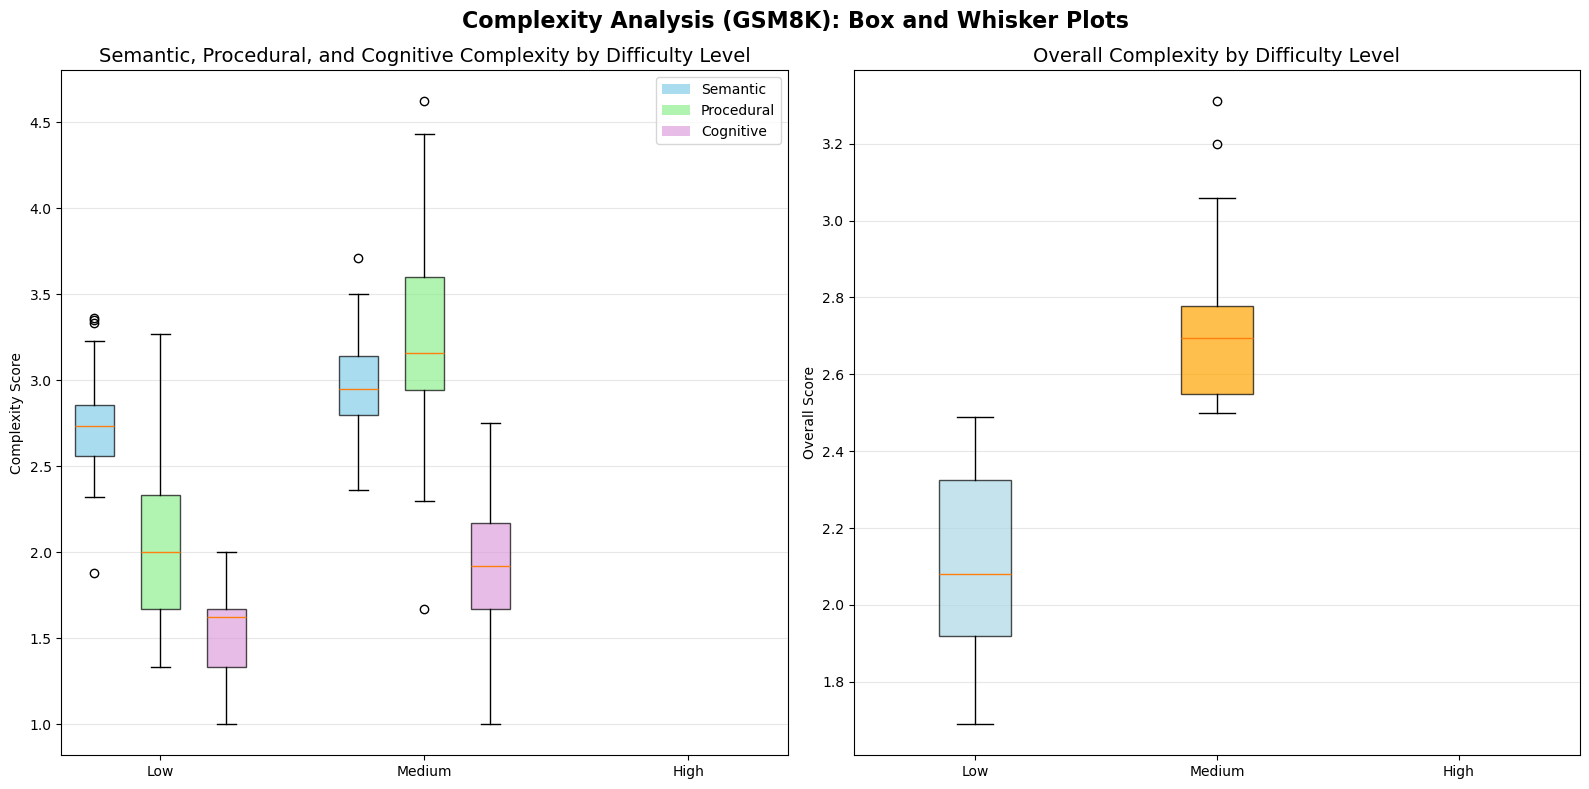

In [20]:
# To plot the distribution of gsm8k data

df = pd.DataFrame(gsm8k_sample)

def score_to_category(score):
    if score < 2.5:
        return "Low"
    elif score < 3.75:
        return "Medium"
    else:
        return "High"

# Create difficulty level based on overall_score
df['difficulty_level'] = df['overall_score'].apply(score_to_category)

# Create figure with 2 subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
fig.suptitle('Complexity Analysis (GSM8K): Box and Whisker Plots', fontsize=16, fontweight='bold')

# Define colors for difficulty levels
colors = {'Low': 'lightblue', 'Medium': 'orange', 'High': 'lightcoral'}
difficulty_levels = ['Low', 'Medium', 'High']

# Plot 1: Semantic, Procedural, and Cognitive Complexity by Difficulty Level
ax1 = axes[0]

# Prepare data for grouped box plot
semantic_by_difficulty = [df[df['difficulty_level'] == level]['semantic_score'].values 
                         for level in difficulty_levels]
procedural_by_difficulty = [df[df['difficulty_level'] == level]['procedural_score'].values 
                           for level in difficulty_levels]
cognitive_by_difficulty = [df[df['difficulty_level'] == level]['cognitive_score'].values 
                          for level in difficulty_levels]

# Create positions for grouped boxes
positions_semantic = [1, 5, 9]
positions_procedural = [2, 6, 10]
positions_cognitive = [3, 7, 11]

# Plot the three complexity types
bp1 = ax1.boxplot(semantic_by_difficulty, positions=positions_semantic, widths=0.6, 
                  patch_artist=True, boxprops=dict(facecolor='skyblue', alpha=0.7))
bp2 = ax1.boxplot(procedural_by_difficulty, positions=positions_procedural, widths=0.6, 
                  patch_artist=True, boxprops=dict(facecolor='lightgreen', alpha=0.7))
bp3 = ax1.boxplot(cognitive_by_difficulty, positions=positions_cognitive, widths=0.6, 
                  patch_artist=True, boxprops=dict(facecolor='plum', alpha=0.7))

# Customize first plot
ax1.set_title('Semantic, Procedural, and Cognitive Complexity by Difficulty Level', fontsize=14)
ax1.set_ylabel('Complexity Score')
ax1.set_xticks([2, 6, 10])
ax1.set_xticklabels(difficulty_levels)
ax1.grid(axis='y', alpha=0.3)

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='skyblue', alpha=0.7, label='Semantic'),
                  Patch(facecolor='lightgreen', alpha=0.7, label='Procedural'),
                  Patch(facecolor='plum', alpha=0.7, label='Cognitive')]
ax1.legend(handles=legend_elements, loc='upper right')

# Plot 2: Overall Complexity by Difficulty Level
ax2 = axes[1]
overall_by_difficulty = [df[df['difficulty_level'] == level]['overall_score'].values 
                        for level in difficulty_levels]

bp4 = ax2.boxplot(overall_by_difficulty, labels=difficulty_levels, patch_artist=True)
for patch, color in zip(bp4['boxes'], [colors[level] for level in difficulty_levels]):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax2.set_title('Overall Complexity by Difficulty Level', fontsize=14)
ax2.set_ylabel('Overall Score')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig("gsm8k.png")
plt.show()

In [21]:
framework = AdaptiveCoTFramework(
        model_name="meta-llama/Llama-3.2-1B",
        taxonomy_df= gsm8k_sample
    )

# pick model
# deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B
#google/flan-t5-base

Loading model and tokenizer: meta-llama/Llama-3.2-1B
Loaded taxonomy DataFrame with 100 rows


In [22]:
results = framework.evaluate_all_strategies(
        difficulties=["low", "medium", "high"],
        num_problems_per_difficulty=10
    )
    
print(results)

Evaluating on low difficulty problems
Evaluating adaptive strategy


Evaluating adaptive:   0%|                                                                      | 0/52 [00:05<?, ?it/s]

KeyboardInterrupt



# SVAMP

In [9]:
train_svamp = pd.read_csv("train-svamp.csv")
train_svamp.head()

,ID,Body,Question,Equation,Answer,Type,question_concat
0,chal-777,There are 87 oranges and 290 bananas in Philip...,How big is each group of bananas?,( 290.0 / 2.0 ),145,Common-Division,There are 87 oranges and 290 bananas in Philip...
1,chal-508,Marco and his dad went strawberry picking. Mar...,How much did Marco's strawberries weigh?,( 30.0 - 11.0 ),19,Subtraction,Marco and his dad went strawberry picking. Mar...
2,chal-896,Edward spent $ 6 to buy 2 books each book cost...,How much did each book cost?,( 6.0 / 2.0 ),3,Common-Division,Edward spent $ 6 to buy 2 books each book cost...
3,chal-923,Frank was reading through his favorite book. T...,How many pages are in each chapter?,( 594.0 / 3.0 ),198,Common-Division,Frank was reading through his favorite book. T...
4,chal-34,There were 78 dollars in Olivia's wallet. She ...,How much money does she have left?,( 78.0 - 15.0 ),63,Subtraction,There were 78 dollars in Olivia's wallet. She ...


In [10]:
test_svamp = pd.read_csv("test-svamp.csv")
test_svamp.head()

,ID,Body,Question,Equation,Answer,Type,question_concat
0,chal-736,Winter is almost here and most animals are mig...,How many more bird families flew away to afric...,( 62.0 - 35.0 ),27,Subtraction,Winter is almost here and most animals are mig...
1,chal-162,Paige raised 7 goldfish and 12 catfish in the ...,How many fishes disappeared?,( ( 7.0 + 12.0 ) - 15.0 ),4,Subtraction,Paige raised 7 goldfish and 12 catfish in the ...
2,chal-349,Marco and his dad went strawberry picking. Tog...,How much did his dad's strawberries weigh now?,( ( 22.0 - 36.0 ) + 30.0 ),16,Addition,Marco and his dad went strawberry picking. Tog...
3,chal-390,Debby bought 200 water bottles and 256 soda bo...,How many days would the soda bottles last?,( 256.0 / 4.0 ),64,Common-Division,Debby bought 200 water bottles and 256 soda bo...
4,chal-781,There were 106 dollars in Olivia's wallet. Aft...,How much did she spend at the supermarket?,( ( 106.0 - 26.0 ) - 49.0 ),31,Subtraction,There were 106 dollars in Olivia's wallet. Aft...


In [ ]:
svamp = pd.concat([train_svamp, test_svamp],axis=0).reset_index(drop=True)

In [ ]:
svamp_df,results_svamp = analyse_math_dataset(dataset_path='',data = svamp)
svamp_df["Answers"] = svamp["Answer"]
svamp_df.head()

In [ ]:
low_svamp = svamp_df[svamp_df["overall_complexity"]=="Low"].sample(79, random_state=42) 
med_svamp = svamp_df[svamp_df["overall_complexity"]=="Medium"]
svamp_sample = pd.concat([low_svamp, med_svamp],axis=0).reset_index(drop=True)

In [ ]:
svamp_sample.head()

In [ ]:
df = pd.DataFrame(svamp_sample)
def score_to_category(score):
    if score < 2.5:
        return "Low"
    elif score < 3.75:
        return "Medium"
    else:
        return "High"

# Create difficulty level based on overall_score
df['difficulty_level'] = df['overall_score'].apply(score_to_category)

# Create figure with 2 subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
fig.suptitle('Complexity Analysis (SVAMP): Box and Whisker Plots', fontsize=16, fontweight='bold')

# Define colors for difficulty levels
colors = {'Low': 'lightblue', 'Medium': 'orange', 'High': 'lightcoral'}
difficulty_levels = ['Low', 'Medium', 'High']

# Plot 1: Semantic, Procedural, and Cognitive Complexity by Difficulty Level
ax1 = axes[0]

# Prepare data for grouped box plot
semantic_by_difficulty = [df[df['difficulty_level'] == level]['semantic_score'].values 
                         for level in difficulty_levels]
procedural_by_difficulty = [df[df['difficulty_level'] == level]['procedural_score'].values 
                           for level in difficulty_levels]
cognitive_by_difficulty = [df[df['difficulty_level'] == level]['cognitive_score'].values 
                          for level in difficulty_levels]

# Create positions for grouped boxes
positions_semantic = [1, 5, 9]
positions_procedural = [2, 6, 10]
positions_cognitive = [3, 7, 11]

# Plot the three complexity types
bp1 = ax1.boxplot(semantic_by_difficulty, positions=positions_semantic, widths=0.6, 
                  patch_artist=True, boxprops=dict(facecolor='skyblue', alpha=0.7))
bp2 = ax1.boxplot(procedural_by_difficulty, positions=positions_procedural, widths=0.6, 
                  patch_artist=True, boxprops=dict(facecolor='lightgreen', alpha=0.7))
bp3 = ax1.boxplot(cognitive_by_difficulty, positions=positions_cognitive, widths=0.6, 
                  patch_artist=True, boxprops=dict(facecolor='plum', alpha=0.7))

# Customize first plot
ax1.set_title('Semantic, Procedural, and Cognitive Complexity by Difficulty Level', fontsize=14)
ax1.set_ylabel('Complexity Score')
ax1.set_xticks([2, 6, 10])
ax1.set_xticklabels(difficulty_levels)
ax1.grid(axis='y', alpha=0.3)

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='skyblue', alpha=0.7, label='Semantic'),
                  Patch(facecolor='lightgreen', alpha=0.7, label='Procedural'),
                  Patch(facecolor='plum', alpha=0.7, label='Cognitive')]
ax1.legend(handles=legend_elements, loc='upper right')

# Plot 2: Overall Complexity by Difficulty Level
ax2 = axes[1]
overall_by_difficulty = [df[df['difficulty_level'] == level]['overall_score'].values 
                        for level in difficulty_levels]

bp4 = ax2.boxplot(overall_by_difficulty, labels=difficulty_levels, patch_artist=True)
for patch, color in zip(bp4['boxes'], [colors[level] for level in difficulty_levels]):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax2.set_title('Overall Complexity by Difficulty Level', fontsize=14)
ax2.set_ylabel('Overall Score')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig("svamp.png")
plt.show()

In [ ]:
framework = AdaptiveCoTFramework(
        model_name="google/flan-t5-base",
        taxonomy_df= svamp_sample
    )

In [ ]:
results = framework.evaluate_all_strategies(
        difficulties=["low", "medium", "high"],
        num_problems_per_difficulty=10
    )
    
print(results)

# ASDiv

In [ ]:
def edit_question(string, numbers):
    def replace_number(match):
        index = int(match.group(1))
        if index < len(numbers):
            try:
                return str(int(float(numbers[index])))
            except:
                return str(numbers[index])
        return match.group(0)
    
    return re.sub(r'number(\d+)', replace_number, string)


def process_row(row):
    numbers = row['Numbers']
    if isinstance(numbers, str):
        try:
            numbers = ast.literal_eval(numbers.replace(' ', ','))
        except:
            numbers = [float(x) for x in re.findall(r'[\d.]+(?:e[+-]\d+)?', numbers)]
    return edit_question(row['Question'], numbers)
            

In [11]:
train_asdiv = pd.read_csv("train-asdiv.csv")

train_asdiv['question_concat'] = train_asdiv.apply(process_row, axis=1)


train_asdiv.head()

,Question,Numbers,Equation,Answer,group_nums,Body,Ques,Type,Variation Type,id
0,Bryan took a look at his books as well . If Br...,[56. 9.],['*' 'number0' 'number1'],504.0,[12 13 14 18 19 20 27 28 29],Bryan took a look at his books as well . If Br...,how many books does he have in total ?,NaN,NaN,0
1,"For the fifth grade play , the chairs have bee...",[27. 16.],['*' 'number0' 'number1'],432.0,[11 12 13 14 15 16 28 29 30],"For the fifth grade play , the chairs have bee...",How many chairs have been put out for the play ?,NaN,NaN,1
2,There are number0 short trees and number1 tall...,[41. 44. 57.],['+' 'number0' 'number2'],98.0,[ 1 2 3 5 6 7 17 18 19 33 34 35],There are number0 short trees and number1 tall...,How many short trees will the park have when t...,NaN,NaN,2
3,Conner has number0 dollars in his bank account...,[2.5e+04 1.5e+03 8.0e+00],['-' 'number0' '*' 'number1' 'number2'],13000.0,[ 1 2 3 12 13 14 34 35 36 34 35 36],Conner has number0 dollars in his bank account...,How much money will Conner have in his account...,NaN,NaN,3
4,There are number0 dogwood trees currently in t...,[34. 49.],['+' 'number0' 'number1'],83.0,[ 1 2 3 13 14 15 29 30 31],There are number0 dogwood trees currently in t...,How many dogwood trees will the park have when...,NaN,NaN,4


In [12]:
test_asdiv = pd.read_csv("test-asdiv.csv")
test_asdiv['question_concat'] = test_asdiv.apply(process_row, axis=1)
test_asdiv.head()

,Question,Numbers,Equation,Answer,group_nums,Body,Ques,Type,Variation Type,id
0,julia played tag with number0 kids on monday ....,[18. 10.],['-' 'number0' 'number1'],8.0,[ 1 2 3 4 5 6 12 13 14 28 29 30],julia played tag with number0 kids on monday ....,how many more kids did she play with on monday...,Subtraction,[11],0
1,julia played tag with number0 kids on monday ....,[11. 12.],['-' 'number1' 'number0'],1.0,[ 1 2 3 4 5 6 12 13 14 28 29 30],julia played tag with number0 kids on monday ....,how many more kids did she play with on tuesda...,Subtraction,[11],1
2,julia played tag with number0 kids on monday ....,[ 5. 15.],['-' 'number1' 'number0'],10.0,[34 3 4 5 35 36 10 14 25 26 27],julia played tag with number0 kids on monday ....,how many kids did she play with on tuesday ?,Subtraction,[23],2
3,julia played tag with some kids on monday . sh...,[14. 16.],['-' 'number1' 'number0'],2.0,[33 34 35 10 12 13 14 24 25 26],julia played tag with some kids on monday . sh...,how many kids did she play with on monday ?,Subtraction,[23],3
4,julia played tag with number0 kids on monday ....,[16. 12.],['-' 'number0' 'number1'],4.0,[ 3 4 5 6 13 14 15 16 18 28 29 30],julia played tag with number0 kids on monday ....,how many kids did she play with on tuesday ?,Subtraction,[11 23],4


In [ ]:
asdiv = pd.concat([train_asdiv,test_asdiv],axis=0).reset_index(drop=True)
asdiv.head()


In [ ]:
asdiv_df,results_asdiv = analyse_math_dataset(dataset_path='',data = asdiv)
asdiv_df["Answers"] = asdiv["Answer"].astype(int)
asdiv_df.head()

In [ ]:
low_asdiv = asdiv_df[asdiv_df["overall_complexity"]=="Low"].sample(50, random_state=42) 
med_asdiv = asdiv_df[asdiv_df["overall_complexity"]=="Medium"].sample(50, random_state=42) 
asdiv_sample = pd.concat([low_asdiv, med_asdiv],axis=0).reset_index(drop=True)

In [ ]:
asdiv_sample.head()

In [ ]:
df = pd.DataFrame(asdiv_sample)
def score_to_category(score):
    if score < 2.5:
        return "Low"
    elif score < 3.75:
        return "Medium"
    else:
        return "High"

# Create difficulty level based on overall_score
df['difficulty_level'] = df['overall_score'].apply(score_to_category)

# Create figure with 2 subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
fig.suptitle('Complexity Analysis (ASDiv): Box and Whisker Plots', fontsize=16, fontweight='bold')

# Define colors for difficulty levels
colors = {'Low': 'lightblue', 'Medium': 'orange', 'High': 'lightcoral'}
difficulty_levels = ['Low', 'Medium', 'High']

# Plot 1: Semantic, Procedural, and Cognitive Complexity by Difficulty Level
ax1 = axes[0]

# Prepare data for grouped box plot
semantic_by_difficulty = [df[df['difficulty_level'] == level]['semantic_score'].values 
                         for level in difficulty_levels]
procedural_by_difficulty = [df[df['difficulty_level'] == level]['procedural_score'].values 
                           for level in difficulty_levels]
cognitive_by_difficulty = [df[df['difficulty_level'] == level]['cognitive_score'].values 
                          for level in difficulty_levels]

# Create positions for grouped boxes
positions_semantic = [1, 5, 9]
positions_procedural = [2, 6, 10]
positions_cognitive = [3, 7, 11]

# Plot the three complexity types
bp1 = ax1.boxplot(semantic_by_difficulty, positions=positions_semantic, widths=0.6, 
                  patch_artist=True, boxprops=dict(facecolor='skyblue', alpha=0.7))
bp2 = ax1.boxplot(procedural_by_difficulty, positions=positions_procedural, widths=0.6, 
                  patch_artist=True, boxprops=dict(facecolor='lightgreen', alpha=0.7))
bp3 = ax1.boxplot(cognitive_by_difficulty, positions=positions_cognitive, widths=0.6, 
                  patch_artist=True, boxprops=dict(facecolor='plum', alpha=0.7))

# Customize first plot
ax1.set_title('Semantic, Procedural, and Cognitive Complexity by Difficulty Level', fontsize=14)
ax1.set_ylabel('Complexity Score')
ax1.set_xticks([2, 6, 10])
ax1.set_xticklabels(difficulty_levels)
ax1.grid(axis='y', alpha=0.3)

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='skyblue', alpha=0.7, label='Semantic'),
                  Patch(facecolor='lightgreen', alpha=0.7, label='Procedural'),
                  Patch(facecolor='plum', alpha=0.7, label='Cognitive')]
ax1.legend(handles=legend_elements, loc='upper right')

# Plot 2: Overall Complexity by Difficulty Level
ax2 = axes[1]
overall_by_difficulty = [df[df['difficulty_level'] == level]['overall_score'].values 
                        for level in difficulty_levels]

bp4 = ax2.boxplot(overall_by_difficulty, labels=difficulty_levels, patch_artist=True)
for patch, color in zip(bp4['boxes'], [colors[level] for level in difficulty_levels]):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax2.set_title('Overall Complexity by Difficulty Level', fontsize=14)
ax2.set_ylabel('Overall Score')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig("asdiv.png")
plt.show()

In [ ]:
framework = AdaptiveCoTFramework(
        model_name="meta-llama/Llama-3.2-1B",
        taxonomy_df= asdiv_sample
    )

In [ ]:
results = framework.evaluate_all_strategies(
        difficulties=["low", "medium", "high"],
        num_problems_per_difficulty=10
    )
    
print(results)

# Graphing Model Accuracy

In [ ]:
# Load the JSON files
with open('results_703/adaptive_gsm8k_deepseek.json', 'r') as f1:
    gsm8k_data = json.load(f1)

with open('results_703/adaptive_svamp_deepseek.json', 'r') as f2:
    svamp_data = json.load(f2)

with open('results_703/asdiv_deepseek_adaptive.json', 'r') as f3:
    asdiv_data = json.load(f3)

# Extract accuracies for low, medium, and high difficulty levels
accuracy_gsm8k = [
    gsm8k_data["low"]["adaptive"]["low_difficulty_accuracy"],
    gsm8k_data["medium"]["adaptive"]["medium_difficulty_accuracy"],
    gsm8k_data["high"]["adaptive"]["high_difficulty_accuracy"]
]

accuracy_svamp = [
    svamp_data["low"]["adaptive"]["low_difficulty_accuracy"],
    svamp_data["medium"]["adaptive"]["medium_difficulty_accuracy"],
    svamp_data["high"]["adaptive"]["high_difficulty_accuracy"]
]

accuracy_asdiv = [
    asdiv_data["low"]["adaptive"]["low_difficulty_accuracy"],
    asdiv_data["medium"]["adaptive"]["medium_difficulty_accuracy"],
    asdiv_data["high"]["adaptive"]["high_difficulty_accuracy"]
]


# Difficulty labels
difficulties = ['Low', 'Medium', 'High']
x = range(len(difficulties))

# Plotting grouped bar chart
plt.figure(figsize=(5, 3))

bar_width = 0.25
x = range(len(difficulties))

bars1 = plt.bar([i - bar_width for i in x], accuracy_gsm8k, width=bar_width, label='GSM8K', color='skyblue')
bars2 = plt.bar(x, accuracy_svamp, width=bar_width, label='SVAMP', color='salmon')
bars3 = plt.bar([i + bar_width for i in x], accuracy_asdiv, width=bar_width, label='ASDiv', color='mediumseagreen')  

for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height + 0.015, f'{height*100:.1f}%', 
                 ha='center', va='bottom', fontsize=8)

# Aesthetics
plt.xticks(ticks=x, labels=difficulties)
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Adaptive Accuracy by Difficulty Level: DeepSeek Model')
plt.legend()
plt.tight_layout()
plt.savefig("a_deepseek.png")
plt.show()


In [ ]:
with open('results_703/gsm8k_standard_deepseek.json', 'r') as f1:
    gsm8k_data = json.load(f1)

with open('results_703/standard_svamp_deepseek.json', 'r') as f2:
    svamp_data = json.load(f2)

with open('results_703/asdiv_standard_deepseek.json', 'r') as f3:
    asdiv_data = json.load(f3)

# Extract accuracies for low, medium, and high difficulty levels (using "standard")
accuracy_gsm8k = [
    gsm8k_data["low"]["standard"]["low_difficulty_accuracy"],
    gsm8k_data["medium"]["standard"]["medium_difficulty_accuracy"],
    gsm8k_data["high"]["standard"]["high_difficulty_accuracy"]
]

accuracy_svamp = [
    svamp_data["low"]["standard"]["low_difficulty_accuracy"],
    svamp_data["medium"]["standard"]["medium_difficulty_accuracy"],
    svamp_data["high"]["standard"]["high_difficulty_accuracy"]
]

accuracy_asdiv = [
    asdiv_data["low"]["standard"]["low_difficulty_accuracy"],
    asdiv_data["medium"]["standard"]["medium_difficulty_accuracy"],
    asdiv_data["high"]["standard"]["high_difficulty_accuracy"]
]

# Difficulty labels
difficulties = ['Low', 'Medium', 'High']
x = range(len(difficulties))

# Plotting grouped bar chart
plt.figure(figsize=(5, 3))

bar_width = 0.25
x = list(range(len(difficulties)))

bars1 = plt.bar([i - bar_width for i in x], accuracy_gsm8k, width=bar_width, label='GSM8K', color='skyblue')
bars2 = plt.bar(x, accuracy_svamp, width=bar_width, label='SVAMP', color='salmon')
bars3 = plt.bar([i + bar_width for i in x], accuracy_asdiv, width=bar_width, label='ASDiv', color='mediumseagreen')

# Add percentage labels
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height + 0.015, f'{height*100:.1f}%', 
                 ha='center', va='bottom', fontsize=8)

# Aesthetics
plt.xticks(ticks=x, labels=difficulties)
plt.ylim(0, 1.05)
plt.ylabel('Accuracy')
plt.title('Standard Accuracy by Difficulty Level: DeepSeek Model')
plt.legend()
plt.tight_layout()
plt.savefig("s_deepseek.png")
plt.show()

In [ ]:
with open('results_703/adaptive_gsm8k_deepseek.json', 'r') as f1:
    gsm8k_data = json.load(f1)

with open('results_703/svamp_llama_adaptive.json', 'r') as f2:
    svamp_data = json.load(f2)

with open('results_703/asdiv_adaptive_llama.json', 'r') as f3:
    asdiv_data = json.load(f3)

# Extract accuracies for low, medium, and high difficulty levels
accuracy_gsm8k = [
    gsm8k_data["low"]["adaptive"]["low_difficulty_accuracy"],
    gsm8k_data["medium"]["adaptive"]["medium_difficulty_accuracy"],
    gsm8k_data["high"]["adaptive"]["high_difficulty_accuracy"]
]

accuracy_svamp = [
    svamp_data["low"]["adaptive"]["low_difficulty_accuracy"],
    svamp_data["medium"]["adaptive"]["medium_difficulty_accuracy"],
    svamp_data["high"]["adaptive"]["high_difficulty_accuracy"]
]

accuracy_asdiv = [
    asdiv_data["low"]["adaptive"]["low_difficulty_accuracy"],
    asdiv_data["medium"]["adaptive"]["medium_difficulty_accuracy"],
    asdiv_data["high"]["adaptive"]["high_difficulty_accuracy"]
]


# Difficulty labels
difficulties = ['Low', 'Medium', 'High']
x = range(len(difficulties))

# Plotting grouped bar chart
plt.figure(figsize=(5, 3))

bar_width = 0.25
x = range(len(difficulties))

bars1 = plt.bar([i - bar_width for i in x], accuracy_gsm8k, width=bar_width, label='GSM8K', color='skyblue')
bars2 = plt.bar(x, accuracy_svamp, width=bar_width, label='SVAMP', color='salmon')
bars3 = plt.bar([i + bar_width for i in x], accuracy_asdiv, width=bar_width, label='ASDiv', color='mediumseagreen')

# Add percentage labels
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height + 0.015, f'{height*100:.1f}%', 
                 ha='center', va='bottom', fontsize=8)


# Aesthetics
plt.xticks(ticks=x, labels=difficulties)
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Adaptive Accuracy by Difficulty Level: Llama Model')
plt.legend()
plt.tight_layout()
plt.savefig("a_llama.png")
plt.show()

In [ ]:
with open('results_703/gsm8k_standard_llama.json', 'r') as f1:
    gsm8k_data = json.load(f1)

with open('results_703/svamp_llama_standard.json', 'r') as f2:
    svamp_data = json.load(f2)

with open('results_703/asdiv_standard_llama.json', 'r') as f3:
    asdiv_data = json.load(f3)


# Extract accuracies for low, medium, and high difficulty levels (using "standard")
accuracy_gsm8k = [
    gsm8k_data["low"]["standard"]["low_difficulty_accuracy"],
    gsm8k_data["medium"]["standard"]["medium_difficulty_accuracy"],
    gsm8k_data["high"]["standard"]["high_difficulty_accuracy"]
]

accuracy_svamp = [
    svamp_data["low"]["standard"]["low_difficulty_accuracy"],
    svamp_data["medium"]["standard"]["medium_difficulty_accuracy"],
    svamp_data["high"]["standard"]["high_difficulty_accuracy"]
]

accuracy_asdiv = [
    asdiv_data["low"]["standard"]["low_difficulty_accuracy"],
    asdiv_data["medium"]["standard"]["medium_difficulty_accuracy"],
    asdiv_data["high"]["standard"]["high_difficulty_accuracy"]
]

# Difficulty labels
difficulties = ['Low', 'Medium', 'High']
x = range(len(difficulties))

# Plotting grouped bar chart
plt.figure(figsize=(5, 3))

bar_width = 0.25
x = list(range(len(difficulties)))

bars1 = plt.bar([i - bar_width for i in x], accuracy_gsm8k, width=bar_width, label='GSM8K', color='skyblue')
bars2 = plt.bar(x, accuracy_svamp, width=bar_width, label='SVAMP', color='salmon')
bars3 = plt.bar([i + bar_width for i in x], accuracy_asdiv, width=bar_width, label='ASDiv', color='mediumseagreen')

# Add percentage labels
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height + 0.015, f'{height*100:.1f}%', 
                 ha='center', va='bottom', fontsize=8)

# Aesthetics
plt.xticks(ticks=x, labels=difficulties)
plt.ylim(0, 1.05)
plt.ylabel('Accuracy')
plt.title('Standard Accuracy by Difficulty Level: Llama Model')
plt.legend()
plt.tight_layout()
plt.savefig("s_llama.png")
plt.show()


In [ ]:
with open('results_703/gsm8k_adaptive_flan.json', 'r') as f1:
    gsm8k_data = json.load(f1)

with open('results_703/svamp_flan_adaptive.json', 'r') as f2:
    svamp_data = json.load(f2)

with open('results_703/asdiv_adaptive_flan.json', 'r') as f3:
    asdiv_data = json.load(f3)

# Extract accuracies for low, medium, and high difficulty levels
accuracy_gsm8k = [
    gsm8k_data["low"]["adaptive"]["low_difficulty_accuracy"],
    gsm8k_data["medium"]["adaptive"]["medium_difficulty_accuracy"],
    gsm8k_data["high"]["adaptive"]["high_difficulty_accuracy"]
]

accuracy_svamp = [
    svamp_data["low"]["adaptive"]["low_difficulty_accuracy"],
    svamp_data["medium"]["adaptive"]["medium_difficulty_accuracy"],
    svamp_data["high"]["adaptive"]["high_difficulty_accuracy"]
]

accuracy_asdiv = [
    asdiv_data["low"]["adaptive"]["low_difficulty_accuracy"],
    asdiv_data["medium"]["adaptive"]["medium_difficulty_accuracy"],
    asdiv_data["high"]["adaptive"]["high_difficulty_accuracy"]
]


# Difficulty labels
difficulties = ['Low', 'Medium', 'High']
x = range(len(difficulties))

# Plotting grouped bar chart
plt.figure(figsize=(5, 3))

bar_width = 0.25
x = range(len(difficulties))

bars1 = plt.bar([i - bar_width for i in x], accuracy_gsm8k, width=bar_width, label='GSM8K', color='skyblue')
bars2 = plt.bar(x, accuracy_svamp, width=bar_width, label='SVAMP', color='salmon')
bars3 = plt.bar([i + bar_width for i in x], accuracy_asdiv, width=bar_width, label='ASDiv', color='mediumseagreen')

# Add percentage labels
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height + 0.015, f'{height*100:.1f}%', 
                 ha='center', va='bottom', fontsize=8) 


# Aesthetics
plt.xticks(ticks=x, labels=difficulties)
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Adaptive Accuracy by Difficulty Level: Flan Model')
plt.legend()
plt.tight_layout()
plt.savefig("a_flan.png")
plt.show()

In [ ]:
with open('results_703/gsm8k_standard_flan.json', 'r') as f1:
    gsm8k_data = json.load(f1)

with open('results_703/svamp_flan_standard.json', 'r') as f2:
    svamp_data = json.load(f2)

with open('results_703/asdiv_standard_flan.json', 'r') as f3:
    asdiv_data = json.load(f3)

# Extract accuracies for low, medium, and high difficulty levels (using "standard")
accuracy_gsm8k = [
    gsm8k_data["low"]["standard"]["low_difficulty_accuracy"],
    gsm8k_data["medium"]["standard"]["medium_difficulty_accuracy"],
    gsm8k_data["high"]["standard"]["high_difficulty_accuracy"]
]

accuracy_svamp = [
    svamp_data["low"]["standard"]["low_difficulty_accuracy"],
    svamp_data["medium"]["standard"]["medium_difficulty_accuracy"],
    svamp_data["high"]["standard"]["high_difficulty_accuracy"]
]

accuracy_asdiv = [
    asdiv_data["low"]["standard"]["low_difficulty_accuracy"],
    asdiv_data["medium"]["standard"]["medium_difficulty_accuracy"],
    asdiv_data["high"]["standard"]["high_difficulty_accuracy"]
]

# Difficulty labels
difficulties = ['Low', 'Medium', 'High']
x = range(len(difficulties))

# Plotting grouped bar chart
plt.figure(figsize=(5, 3))

bar_width = 0.25
x = list(range(len(difficulties)))

bars1 = plt.bar([i - bar_width for i in x], accuracy_gsm8k, width=bar_width, label='GSM8K', color='skyblue')
bars2 = plt.bar(x, accuracy_svamp, width=bar_width, label='SVAMP', color='salmon')
bars3 = plt.bar([i + bar_width for i in x], accuracy_asdiv, width=bar_width, label='ASDiv', color='mediumseagreen')

# Add percentage labels
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height + 0.015, f'{height*100:.1f}%', 
                 ha='center', va='bottom', fontsize=8)

# Aesthetics
plt.xticks(ticks=x, labels=difficulties)
plt.ylim(0, 1.05)
plt.ylabel('Accuracy')
plt.title('Standard Accuracy by Difficulty Level: Flan Model')
plt.legend()
plt.tight_layout()
plt.savefig("s_flan.png")
plt.show()